In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.linear_model as lm 
import sklearn.ensemble as em 
from sklearn.svm import SVC

In [3]:
import data_clean_for_model

In [4]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)
rseed = 229

In [5]:
# download data 
# if you don't have these csvs, run the preprocessing notebook. 
# Ill turn this this into a py file later, but for now should be fine 
dfs = pd.read_parquet("data/all_processed_df.parquet.gzip")

In [6]:
k = 5
np.random.seed(rseed)
# add outcome var + unique id 
dfs['outcome'] = np.where(dfs['state']=="successful", 1, 0)
dfs['un_id'] = np.arange(0, dfs.shape[0], 1)
dfs['name_len'] = dfs['name'].str.len()
dfs['cv_group'] = np.random.choice(np.arange(0, k), size=dfs.shape[0])
dfs['binned_usd_goal'] = pd.qcut(np.log(dfs['usd_goal']+1), 20)

In [7]:
model_params = {
    'cv': True, 
    #'lnom_frac':0.3, 
    'test_frac':0.3, 
    'lnom_usdgoal':True,
    'dummies':True,
    'rseed': 229,
}
X_train, X_test, y_train, y_test = data_clean_for_model.data_clean_for_model(dfs, "outcome", model_params, cv=model_params['cv'])

In [8]:
del dfs

In [9]:
# specify some model performance funcs 
def rmse(y, yhat):
    print("RMSE:", np.round(np.sqrt( np.mean( (y - yhat)**2 ) ), 3))
    
def acc(y, yhat):
    yhat_rounded = np.round(yhat)
    print("Accuracy:", np.round(np.mean(yhat_rounded == y), 3))
    
def tfpn(y, yhat):
    tp = np.logical_and((y==1), (yhat==1)).sum()
    fp = np.logical_and((y==0), (yhat==1)).sum()
    fn = np.logical_and((y==1), (yhat==0)).sum()
    tn = np.logical_and((y==0), (yhat==0)).sum()
    
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    res = {
        'False Positive Rate':np.round(fpr,3), 
        'False Negative Rate':np.round(fnr,3), 
        'True Positive Rate':np.round(tpr,3), 
        'True Negative Rate':np.round(tnr,3)
    }
    [print(k, ":", v) for k, v in res.items()]

### Models

In [11]:
## 1. Naive approach:
# Idea: what if we just guess the outcome of previous projects within this category
naive = np.array(np.round(X_test['cat_id_outcome_mean']).reset_index(drop=True))
rmse(y_test, naive)
acc(y_test, naive)

RMSE: 0.564
Accuracy: 0.681


In [12]:
## 1.5 OLS: 
ols = lm.LinearRegression(normalize=False)
ols.fit(X_train, y_train)
y_test_hat = ols.predict(X_test)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.375
Accuracy: 0.784


In [15]:
ols_coefs = pd.DataFrame(data={
    'var':X_train.columns, 
    'coef':ols.coef_
}).sort_values('coef', ascending=False)
ols_coefs.head(20)

,var,coef
4,launched_at,1592.036509
5,time_diff,1592.036509
19,cat_id_outcome_std,2.681563
39,dummy_cat_id_22,2.573538
23,dummy_cat_id_1,2.540559
...,...,...
52,dummy_cat_id_35,2.125644
51,dummy_cat_id_34,2.121735
87,dummy_cat_id_262,1.678768
48,dummy_cat_id_31,1.277099


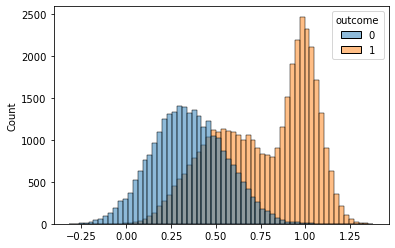

In [13]:
sns.histplot(x=y_test_hat, hue=y_test)

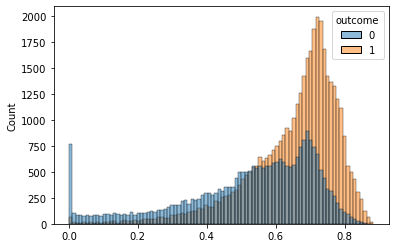

In [20]:
sns.histplot(x=y_test_hat[:, 1], hue=y_test)

In [ ]:
sns.histplot(x=y_test_hat, hue=y_test)

In [21]:
## 2. Lasso
# Since our feature space isn't that large and also not very rich (at least in a linear sense), don't expect great results here  
clf_lasso = lm.Lasso(alpha=3, normalize=False, random_state=rseed)
clf_lasso.fit(X_train, y_train)
y_test_hat = clf_lasso.predict(X_test)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.444
Accuracy: 0.698


(-0.25, 1.25)

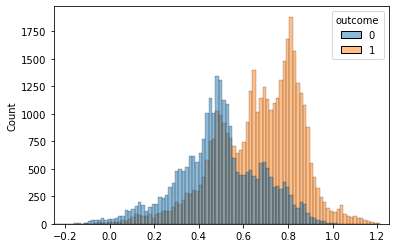

In [25]:
sns.histplot(x=y_test_hat, hue=y_test)
plt.xlim(-0.25, 1.25)

In [22]:
lasso_coefs = pd.DataFrame(data={
    'var':X_train.columns, 
    'coef':clf_lasso.coef_
}).sort_values('coef', ascending=False)
lasso_coefs.head(20)

,var,coef
16,cat_parent_id_usd_goal_mean,5.195886e-06
21,cat_id_usd_goal_std,3.565682e-07
3,deadline,1.904224e-10
4,launched_at,1.197058e-11
0,blurb_len,-0.000000e+00
...,...,...
148,dummy_cat_id_323,-0.000000e+00
149,dummy_cat_id_324,0.000000e+00
136,dummy_cat_id_311,-0.000000e+00
150,dummy_cat_id_325,0.000000e+00


In [15]:
## 3. Ridge
# Similar expectations to lasso, though at least it won't kick out features from our model, so should do a bit better  

# training procedure for a cross-validated ridge, but don't think this is necessary right now 
#clf_ridgecv = lm.RidgeCV(alphas=np.arange(0.1, 1, 0.02), cv=10).fit(X_train_lnom, y_train)
#print(clf_ridgecv.alpha_)
#y_test_hat = clf_ridgecv.predict(X_test_lnom)
#rmse(y_test, y_test_hat)
#acc(y_test, y_test_hat)
# train ridge 
clf_ridge = lm.Ridge(alpha=0.95, normalize=False, random_state=rseed)
clf_ridge.fit(X_train_lnom, y_train)
y_test_hat = clf_ridge.predict(X_test_lnom)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.437
Accuracy: 0.71


/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.23777e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [27]:
## 4. Logistic Reg  
# Similar expectations to lasso + ridge 
# To avoid regularization set C to be very large and/or penalty to none 
glf = lm.LogisticRegression(C=10000, random_state=rseed, penalty='none', class_weight='balanced')
glf.fit(X_train, y_train)
#print("Coefficients:", glf.intercept_, np.round(glf.coef_, 3)) 
y_test_hat_proba = glf.predict_proba(X_test)
y_test_hat = glf.predict(X_test)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


RMSE: 0.604
Accuracy: 0.636


In [ ]:
#### ---> DON'T RUN THIS <--- ####
# this seems very slow and honestly don't have great results
# definitely should look into improving SVM as it has potential, but...

## 5. SVM 
svm = SVC(C=0.1, random_state=rseed, verbose=True)
svm.fit(X_train_lnom, y_train)
y_test_hat = svm.predict(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

[LibSVM]

In [48]:
param_grid = {
    'n_estimators': [10, 20, 30], 
    'max_depth': [10, 15, 25], 
    'max_features': ['auto'], 
    'min_samples_split':[2, 5, 10], 
    'min_samples_leaf':[1, 5, 10], 
    'bootstrap': [False]
    
}
# run grid search over parameters using 5 fold CV verbose on 
grid_rf = GridSearchCV(em.RandomForestRegressor(random_state=rseed), param_grid, cv=5, verbose=2)
grid_rf.fit(X_train_lnom.drop(columns=['usd_goal']), X_train_lnom['usd_goal'])
print(grid_rf.best_params_)
usd_goal_pred = grid_rf.predict(X_train_lnom.drop(columns=['usd_goal']))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.3s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   2.2s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total

In [17]:
##### ---> NOTE: this will take a while to execute 

## 6. Random Forest 
# set up a parameter grid to find optimal parameters
param_grid = {
    'n_estimators': [5, 10, 20], 
    'max_depth': [5, 10, 15, 25, 35], 
    'max_features': ['auto', 'sqrt'], 
    'min_samples_split':[2, 3, 5, 10], 
    'min_samples_leaf':[1, 2, 3, 10], 
    'bootstrap': [True, False]
    
}
param_grid = {
    'n_estimators': [10, 20, 30], 
    'max_depth': [10, 15, 25], 
    'max_features': ['auto'], 
    'min_samples_split':[2, 5, 10], 
    'min_samples_leaf':[1, 5, 10], 
    'bootstrap': [False]
    
}
# run grid search over parameters using 5 fold CV verbose on 
grid_rf = GridSearchCV(em.RandomForestClassifier(random_state=rseed, class_weight='balanced'), param_grid, cv=5, verbose=2)
grid_rf.fit(X_train_lnom, y_train)
print(grid_rf.best_params_)
y_test_hat = grid_rf.predict(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)
# OLD: best params = {'bootstrap': False, 'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.8s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   1.9s


KeyboardInterrupt: 

In [18]:
## 6. Random Forest (cont. )
# selected optimal params from cell above
best_params = {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 20, 'max_features': 'auto', 'bootstrap':False}
#best params w/ usd goal lnoms as well 
best_params = {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 30, 'max_features': 'auto', 'bootstrap': False}
# prams
best_params = {'bootstrap': False, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 30}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train_lnom, y_train)
y_test_hat = rf.predict(X_test_lnom)
y_test_hat_proba = rf.predict_proba(X_test_lnom)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

1    21154
0    17565
dtype: int64
RMSE: 0.519
Accuracy: 0.73


In [19]:
tfpn(y_test, y_test_hat)
print("F1 score", np.round(metrics.f1_score(y_test, y_test_hat), 3))

False Positive Rate : 0.271
False Negative Rate : 0.269
True Positive Rate : 0.731
True Negative Rate : 0.729
F1 score 0.764


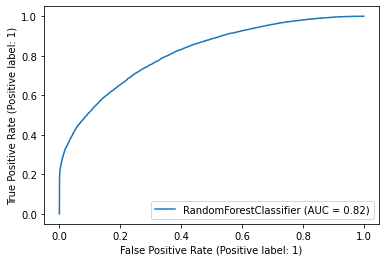

In [20]:
metrics.plot_roc_curve(rf, X_test_lnom, y_test)

#### Generate some plots from RF output

Text(0.5, 0, 'Predicted Probabilities')

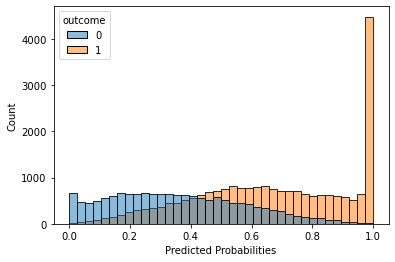

In [21]:
sns.histplot(x=y_test_hat_proba[:, 1], hue=y_test)
plt.xlabel("Predicted Probabilities")

<AxesSubplot:ylabel='Density'>

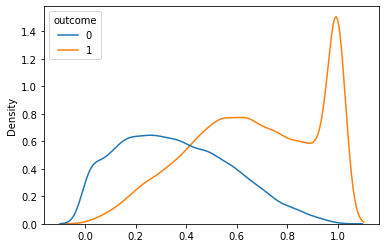

In [22]:
sns.kdeplot(x=y_test_hat_proba[:, 1], hue=y_test)

<AxesSubplot:xlabel='predicted', ylabel='observed'>

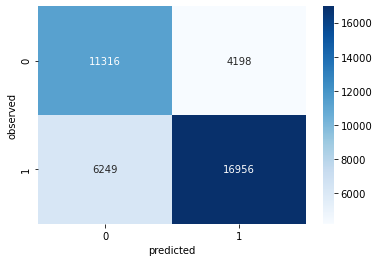

In [23]:
rf_preds = pd.DataFrame({'observed':y_test, 'predicted':y_test_hat})
sns.heatmap(pd.crosstab(rf_preds['observed'], rf_preds['predicted']), annot=True, cmap='Blues', fmt='g')

In [24]:
rf_impt_std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

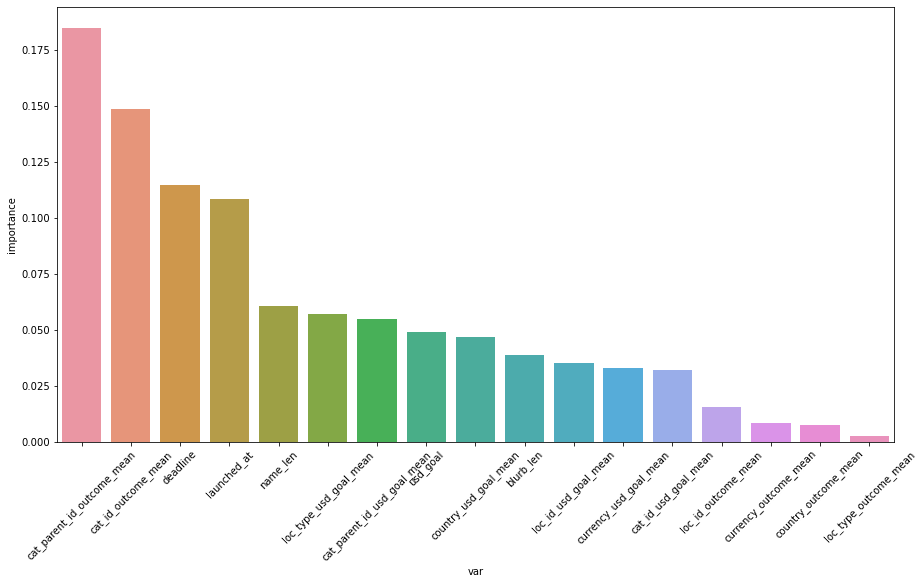

In [25]:
rf_impt = pd.DataFrame({'var':X_cols_all, 'importance':rf.feature_importances_}).sort_values('importance', ascending=False)
plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(x="var", y="importance", data=rf_impt, ci="sd")
plt.xticks(rotation=45)
plt.show()

In [31]:
nb_proba_train = np.load("data/res/multi_nb_preds_train.npy")
nb_proba_test = np.load("data/res/multi_nb_preds.npy")
X_train_lnom2 = X_train_lnom.copy()
X_test_lnom2 = X_test_lnom.copy()
X_train_lnom2['nb_proba'] = nb_proba_train[:, 1]
X_test_lnom2['nb_proba'] = nb_proba_test[:, 1]
best_params = {'bootstrap': False, 'max_depth': 45, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 30}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train_lnom2, y_train)
y_test_hat2 = rf.predict(X_test_lnom2)
#y_test_hat_proba = rf.predict_proba(X_test_lnom2)
print(pd.Series(y_test_hat2).value_counts())
rmse(y_test, y_test_hat2)
acc(y_test, y_test_hat2)

1    21374
0    17345
dtype: int64
RMSE: 0.519
Accuracy: 0.73


In [34]:
w2v_train = np.load("data/res/w2v_Xtrain_avg.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg.npy")
X_train_lnom3 = pd.concat((X_train_lnom2, pd.DataFrame(w2v_train)), axis=1)
X_test_lnom3 = pd.concat((X_test_lnom2, pd.DataFrame(w2v_test)), axis=1)
best_params = {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 30}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train_lnom3, y_train)
y_test_hat3 = rf.predict(X_test_lnom3)
#y_test_hat_proba = rf.predict_proba(X_test_lnom2)
print(pd.Series(y_test_hat3).value_counts())
rmse(y_test, y_test_hat3)
acc(y_test, y_test_hat3)

1    23897
0    14822
dtype: int64
RMSE: 0.514
Accuracy: 0.736


In [36]:
w2v_train = np.load("data/res/w2v_Xtrain_avg.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg.npy")
X_train_lnom3 = pd.concat((X_train_lnom2, pd.DataFrame(w2v_train)), axis=1)
X_test_lnom3 = pd.concat((X_test_lnom2, pd.DataFrame(w2v_test)), axis=1)
best_params = {'bootstrap': False, 'max_depth': 40, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 40}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train_lnom3, y_train)
y_test_hat3 = rf.predict(X_test_lnom3)
#y_test_hat_proba = rf.predict_proba(X_test_lnom2)
print(pd.Series(y_test_hat3).value_counts())
rmse(y_test, y_test_hat3)
acc(y_test, y_test_hat3)

1    23887
0    14832
dtype: int64
RMSE: 0.51
Accuracy: 0.74


In [ ]:
#### misc stuff re: dummy encodings: 

def add_dummies(df, dummy_cols):
    return pd.get_dummies(df, drop_first=False, dummy_na=True, columns=dummy_cols)


# specify columns
y_col = "outcome"
# y_col = ["usd_goal"]
X_cols = ["blurb_len", "spotlight", "staff_pick", "cat_position",]
X_dummy_cols = np.concatenate((
    dfs_full.columns[dfs_full.columns.str.startswith("currency")],
    dfs_full.columns[dfs_full.columns.str.startswith("country")], 
    dfs_full.columns[dfs_full.columns.str.startswith("cat_id")], 
    dfs_full.columns[dfs_full.columns.str.startswith("cat_parent_id")], 
    #dfs_full.columns[dfs_full.columns.str.startswith("loc_id")], 
    dfs_full.columns[dfs_full.columns.str.startswith("loc_type")], 
))
X_lnom_cols = pd.Series(dummy_cols) + "_mean"
#X_cols_all = np.concatenate((X_cols, X_dummy_cols))
X_cols_all = np.concatenate((X_cols, X_lnom_cols))


#X = dfs_full[X_cols_all].astype(float)
#y = np.array(dfs_full[y_col])
X = dfs_lnom[X_cols_all].astype(float)
y = np.array(dfs_lnom[y_col])